Let's make Manhattan plots. The following code sets up the relative lengths of each genome so that the lengths are accurate on the Manhattan plots. The cells after contain plotting and plot annotation code.

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_table('/Users/guhan/Dropbox/ukbb-tools/13_mrp/biomarkers_mrp_rv_ma_exome_gbe.tsv.gz')
gene = pd.read_table('/Users/guhan/Dropbox/ukbb-tools/13_mrp/ref/exome_gene_chr_pos.tsv')
bio = pd.read_table('/Users/guhan/Dropbox/ukbb-tools/13_mrp/sumstat_paths.tsv')
gene.columns = ['gene','chrom','pos']
gene = gene.replace({'chrom': 'X'}, '23')
gene = gene.replace({'chrom': 'Y'}, '24')
gene.chrom = gene.chrom.astype(int)
df = df.merge(gene)
df['to_plot'] = df['log_10_BF_study_similar_var_independent_sigma_m_mpc_pli_pav']
df.loc[df['log_10_BF_study_similar_var_independent_sigma_m_mpc_pli_pav'] > 10, 'to_plot'] = 10 + np.log10(df['log_10_BF_study_similar_var_independent_sigma_m_mpc_pli_pav'])
df.loc[df['log_10_BF_study_similar_var_independent_sigma_m_mpc_pli_pav'] <= 0, 'to_plot'] = 0
df['GBE_short_name'] = df['GBE_short_name'].str.replace('EGFR', 'eGFR')

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [3]:
chrom_sizes = pd.Series(
    {1: 248956422,
     10: 133797422,
     11: 135086622,
     12: 133275309,
     13: 114364328,
     14: 107043718,
     15: 101991189,
     16: 90338345,
     17: 83257441,
     18: 80373285,
     19: 58617616,
     2: 242193529,
     20: 64444167,
     21: 46709983,
     22: 50818468,
     23: 156040895,
     24: 57227415,
     3: 198295559,
     4: 190214555,
     5: 181538259,
     6: 170805979,
     7: 159345973,
     8: 145138636,
     9: 138394717,
    }
)
chrom_sizes = chrom_sizes.sort_index()
chrom_sizes_norm = chrom_sizes / chrom_sizes.max()

In [4]:
def calculate_left_right_chr(total_length):
    right = chrom_sizes_norm.cumsum()
    right = right / right[24] * total_length
    left = chrom_sizes_norm.cumsum() - chrom_sizes_norm[1]
    left = pd.Series(0, range(1, 25))
    left[1:25] = right[0:23].values
    return left, right

def plot_manhattan(res, ax, title, col='log_10_BF_study_similar_var_independent_sigma_m_mpc_pli_pav', loc='lower left', legend=True):
    # Assign x coordinates for each association.
    res['xpos'] = np.nan
    chrom_vc = res['chrom'].value_counts()
    # total_length is arbitrary, but it's a little easier than working with the 
    # normalize chromosome sizes to avoid small numbers.
    total_length = 1000
    
    left, right = calculate_left_right_chr(total_length)
    
    #Assign X positions to each variant
    for chrom in chrom_vc.keys():
        res.loc[res['chrom'] == chrom, 'xpos'] = np.linspace(
            left[chrom], right[chrom], chrom_vc[chrom])
    
    # Assign colors to each variant based on BF value
    grey = mpl.colors.to_rgb('grey')
    light_grey = (0.9, 0.9, 0.9)
    middle_grey = (0.8, 0.8, 0.8)
    res['color'] = 'black'
    for chrom in range(1, 25)[0::2]:
        ind = res[(res[col] < 5) & (res['chrom'] == chrom)].index
        res.loc[ind, 'color'] = pd.Series([grey for x in ind], index=ind)
    for chrom in range(1, 25)[1::2]:
        ind = res[(res[col] < 5) & (res['chrom'] == chrom)].index
        res.loc[ind, 'color'] = pd.Series([middle_grey for x in ind], index=ind)
    
    # Plot
    for i,ind in enumerate([
        res[res[col] < 5].index,
    ]):
        if len(ind) > 0:
            ax.scatter(
                res.loc[ind, 'xpos'], 
                res.loc[ind, col], 
                color=res.loc[ind, 'color'], 
                s=15, 
                alpha=0.75,
                rasterized=True,
            )
    phenos = np.unique(res['GBE_short_name'])
    for i, pheno in enumerate(phenos):
        for ind in ([
            res[(res[col] >= 5) & (res['GBE_short_name'] == pheno)].index,
        ]):
            if len(ind) > 0:
                ax.scatter(
                    res.loc[ind, 'xpos'], 
                    res.loc[ind, col], 
                    color=sns.color_palette("Paired", 12)[i], 
                    s=15, 
                    alpha=0.75,
                    rasterized=True,
                    label=pheno,
                )
#     ax.grid(axis='x')
    ax.grid(axis='y')
    ax.grid(axis='y', alpha=0.5, ls='--')
    
    ax.set_xlim(-5, total_length + 5)
    ymin, ymax = ax.get_ylim()
    ax.set_ylim(-2, 14)
    # Set chromosome labels
    ind = list(range(1, 25)[0::2])
    ax.set_xticks(left[ind] + (right[ind] - left[ind]) / 2)
    x_ind = [str(i) for i in ind]
    x_ind[-1] = 'X'
    ax.set_xticklabels(x_ind, fontsize=8)
    y_ind = list(range(-2,16)[0::2])
    y_ind[-2], y_ind[-1] = 100, 1000
    ax.set_yticklabels(y_ind, fontsize=8)
    ax.set_ylabel('$\log_{10}$ Bayes Factor', fontsize=8)
    ax.set_xlabel('Chromosome', fontsize=8)
    for t in ax.get_xticklabels() + ax.get_yticklabels():
        t.set_fontsize(8)
    if legend:
        ax.legend(fontsize=5, framealpha=0.5, frameon=True, facecolor='white',
                  loc=loc, ncol=len(np.unique(res['GBE_short_name'])), columnspacing=1)

    title = title[0].upper() + title[1:]
    ax.set_title(title, fontsize=12)
    #ax.set_ylim(global_ymin, global_ymax)
    
    return ax, res

In [5]:
def add_annotations(df, ax, offsets, thresh, col = 'log_10_BF_study_similar_var_independent_sigma_m_mpc_pli_pav'):
    delete = ['UGT1A1', 'UGT1A3', 'UGT1A4', 'UGT1A5', 'UGT1A9','UGT1A10']
    df = df[df[col] > thresh]
    df['annot'] = df['GBE_short_name'].str.cat(df['gene'], sep=': ')
#     df = df[~(df['annot'].isin(list(assocs['annot'])))]
    df = df.sort_values(col, ascending=False)
    df = df[~(df['gene'].duplicated())]
    for annotation in offsets.keys():
        if annotation not in list(df['annot']):
            print(annotation)
    for i in range(len(df))[:-1]:
        annot = df.iloc[i]['annot']
        gene = df.iloc[i]['gene']
        #if (',' not in annot):
        if gene not in delete:
            if (annot in offsets.keys()):
                offset = offsets[annot]
            else:
                offset = (10, 9)
            if annot in list(assocs['annot']):
                text_color = (0.8, 0.8, 0.8)
                face_color, edge_color = 'grey', 'grey'
            else:
                text_color = mpl.colors.to_rgb('black')
                face_color, edge_color = 'black', 'black'
            ax.annotate(
                gene, 
                xy=(df.iloc[i].xpos, df.iloc[i][col]),
                xycoords='data',
                xytext=offset,
                textcoords='offset points',
                fontsize=5,
                color=text_color,
                style='italic',
                arrowprops=dict(
                    arrowstyle='simple', 
                    facecolor=face_color, 
                    edgecolor=edge_color,
                    alpha=0.25, 
                    shrinkB=4,
                )
            )
    return(ax)

In [6]:
def showplot(df, title, offsets, thresh):
    fig = plt.figure(figsize=(12, 7), dpi=300)
    gs = gridspec.GridSpec(1, 1)
    ax = fig.add_subplot(gs[0, 0])
    ax, res = plot_manhattan(df, ax, title = title, col='to_plot')
    ax = add_annotations(res, ax, offsets, thresh, col='to_plot')
    #ax.set_ylim(None, ax.get_ylim()[1] + 10)
    plt.savefig(title + '.png', format='png')

In [7]:
# Annotations
pav_nasa = pd.read_table('pav_nasa.txt', skiprows=1)
ptv_nasa = pd.read_table('ptv_nasa.txt', skiprows=1)
pav_nasa = pav_nasa[pav_nasa['CHROM'].notna()]
ptv_nasa = ptv_nasa[pav_nasa['CHROM'].notna()]
assocs = pd.concat([pav_nasa[['Trait', 'Gene symbol']], ptv_nasa[['Trait', 'Gene symbol']]]).drop_duplicates()
assocs.columns = ['GBE_short_name', 'gene']
assocs = assocs.assign(annot = assocs['GBE_short_name'].str.cat(assocs['gene'], sep=": "))
assocs

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


,GBE_short_name,gene,annot
0,Cystatin C,ARHGEF16,Cystatin C: ARHGEF16
1,Alanine aminotransferase,ARHGEF19,Alanine aminotransferase: ARHGEF19
2,Albumin,ARHGEF19,Albumin: ARHGEF19
3,Aspartate aminotransferase,ARHGEF19,Aspartate aminotransferase: ARHGEF19
4,Gamma glutamyltransferase,ARHGEF19,Gamma glutamyltransferase: ARHGEF19
...,...,...,...
49,Vitamin D,SDR42E1,Vitamin D: SDR42E1
53,Direct bilirubin,ZNF563,Direct bilirubin: ZNF563
54,Total bilirubin,ZNF563,Total bilirubin: ZNF563
56,Cystatin C,CST3,Cystatin C: CST3


Bone_and_Joint


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Cardiovascular
Diabetes
Hormone
Liver
Renal


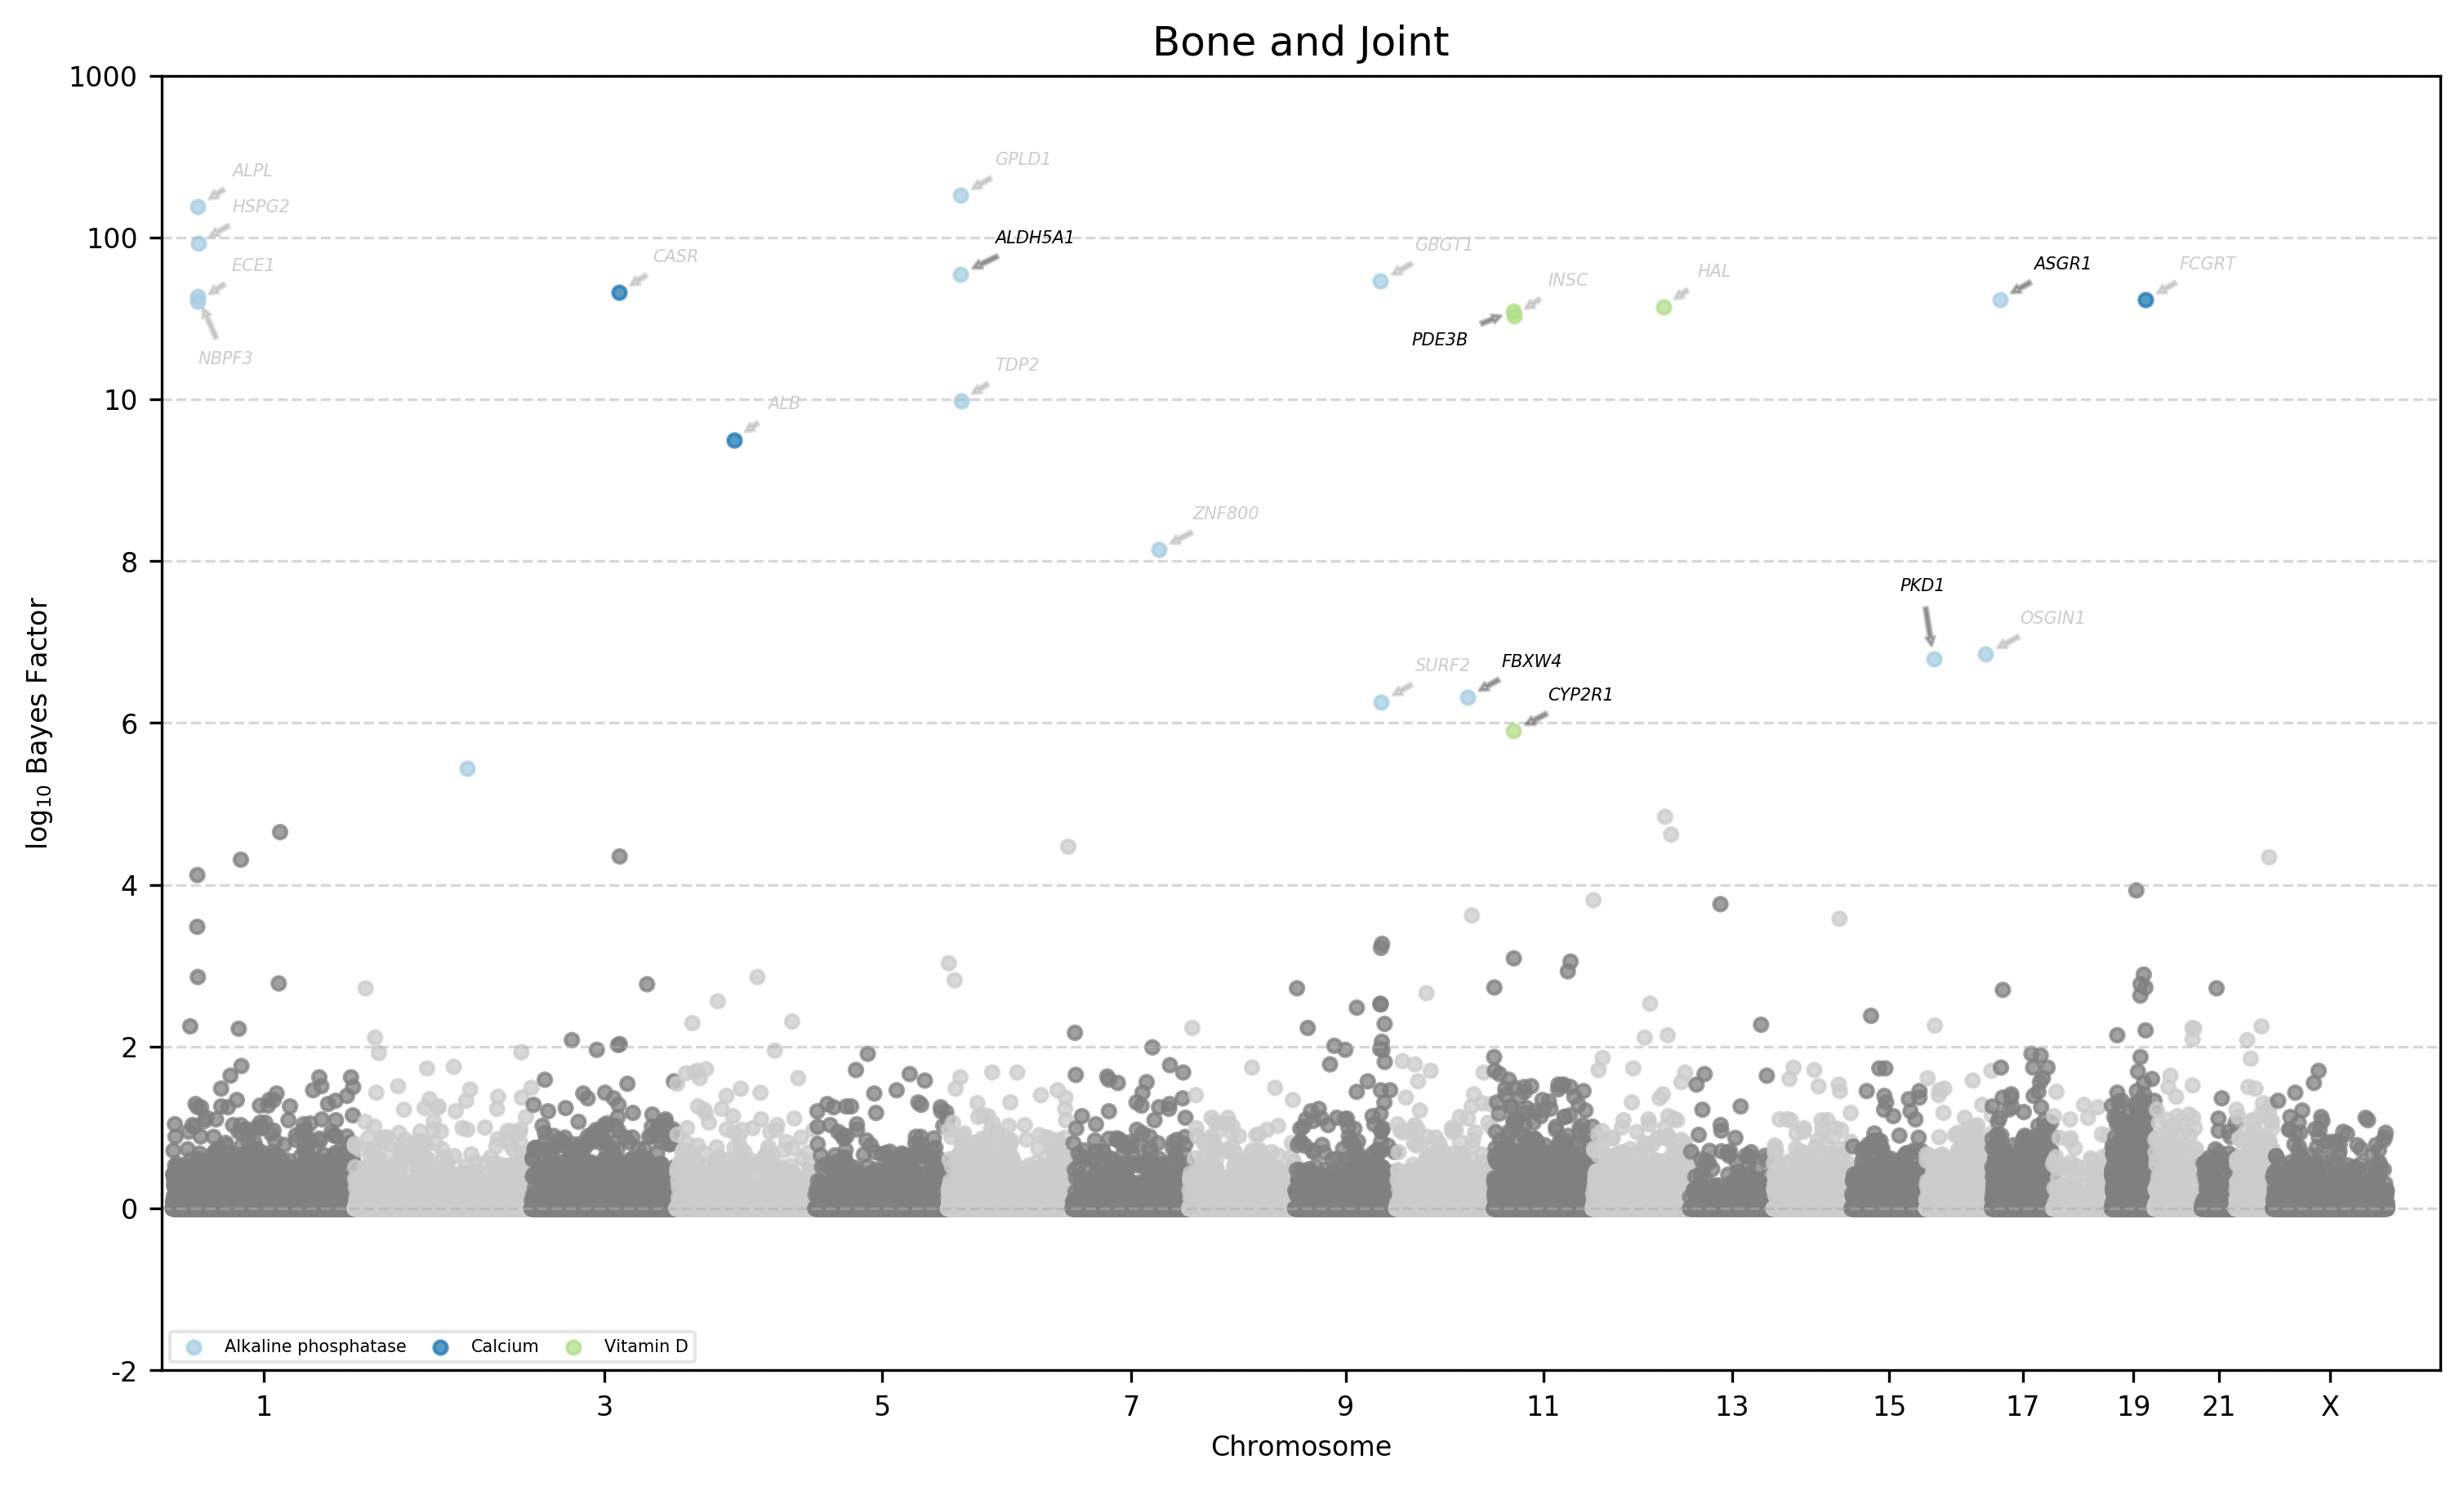

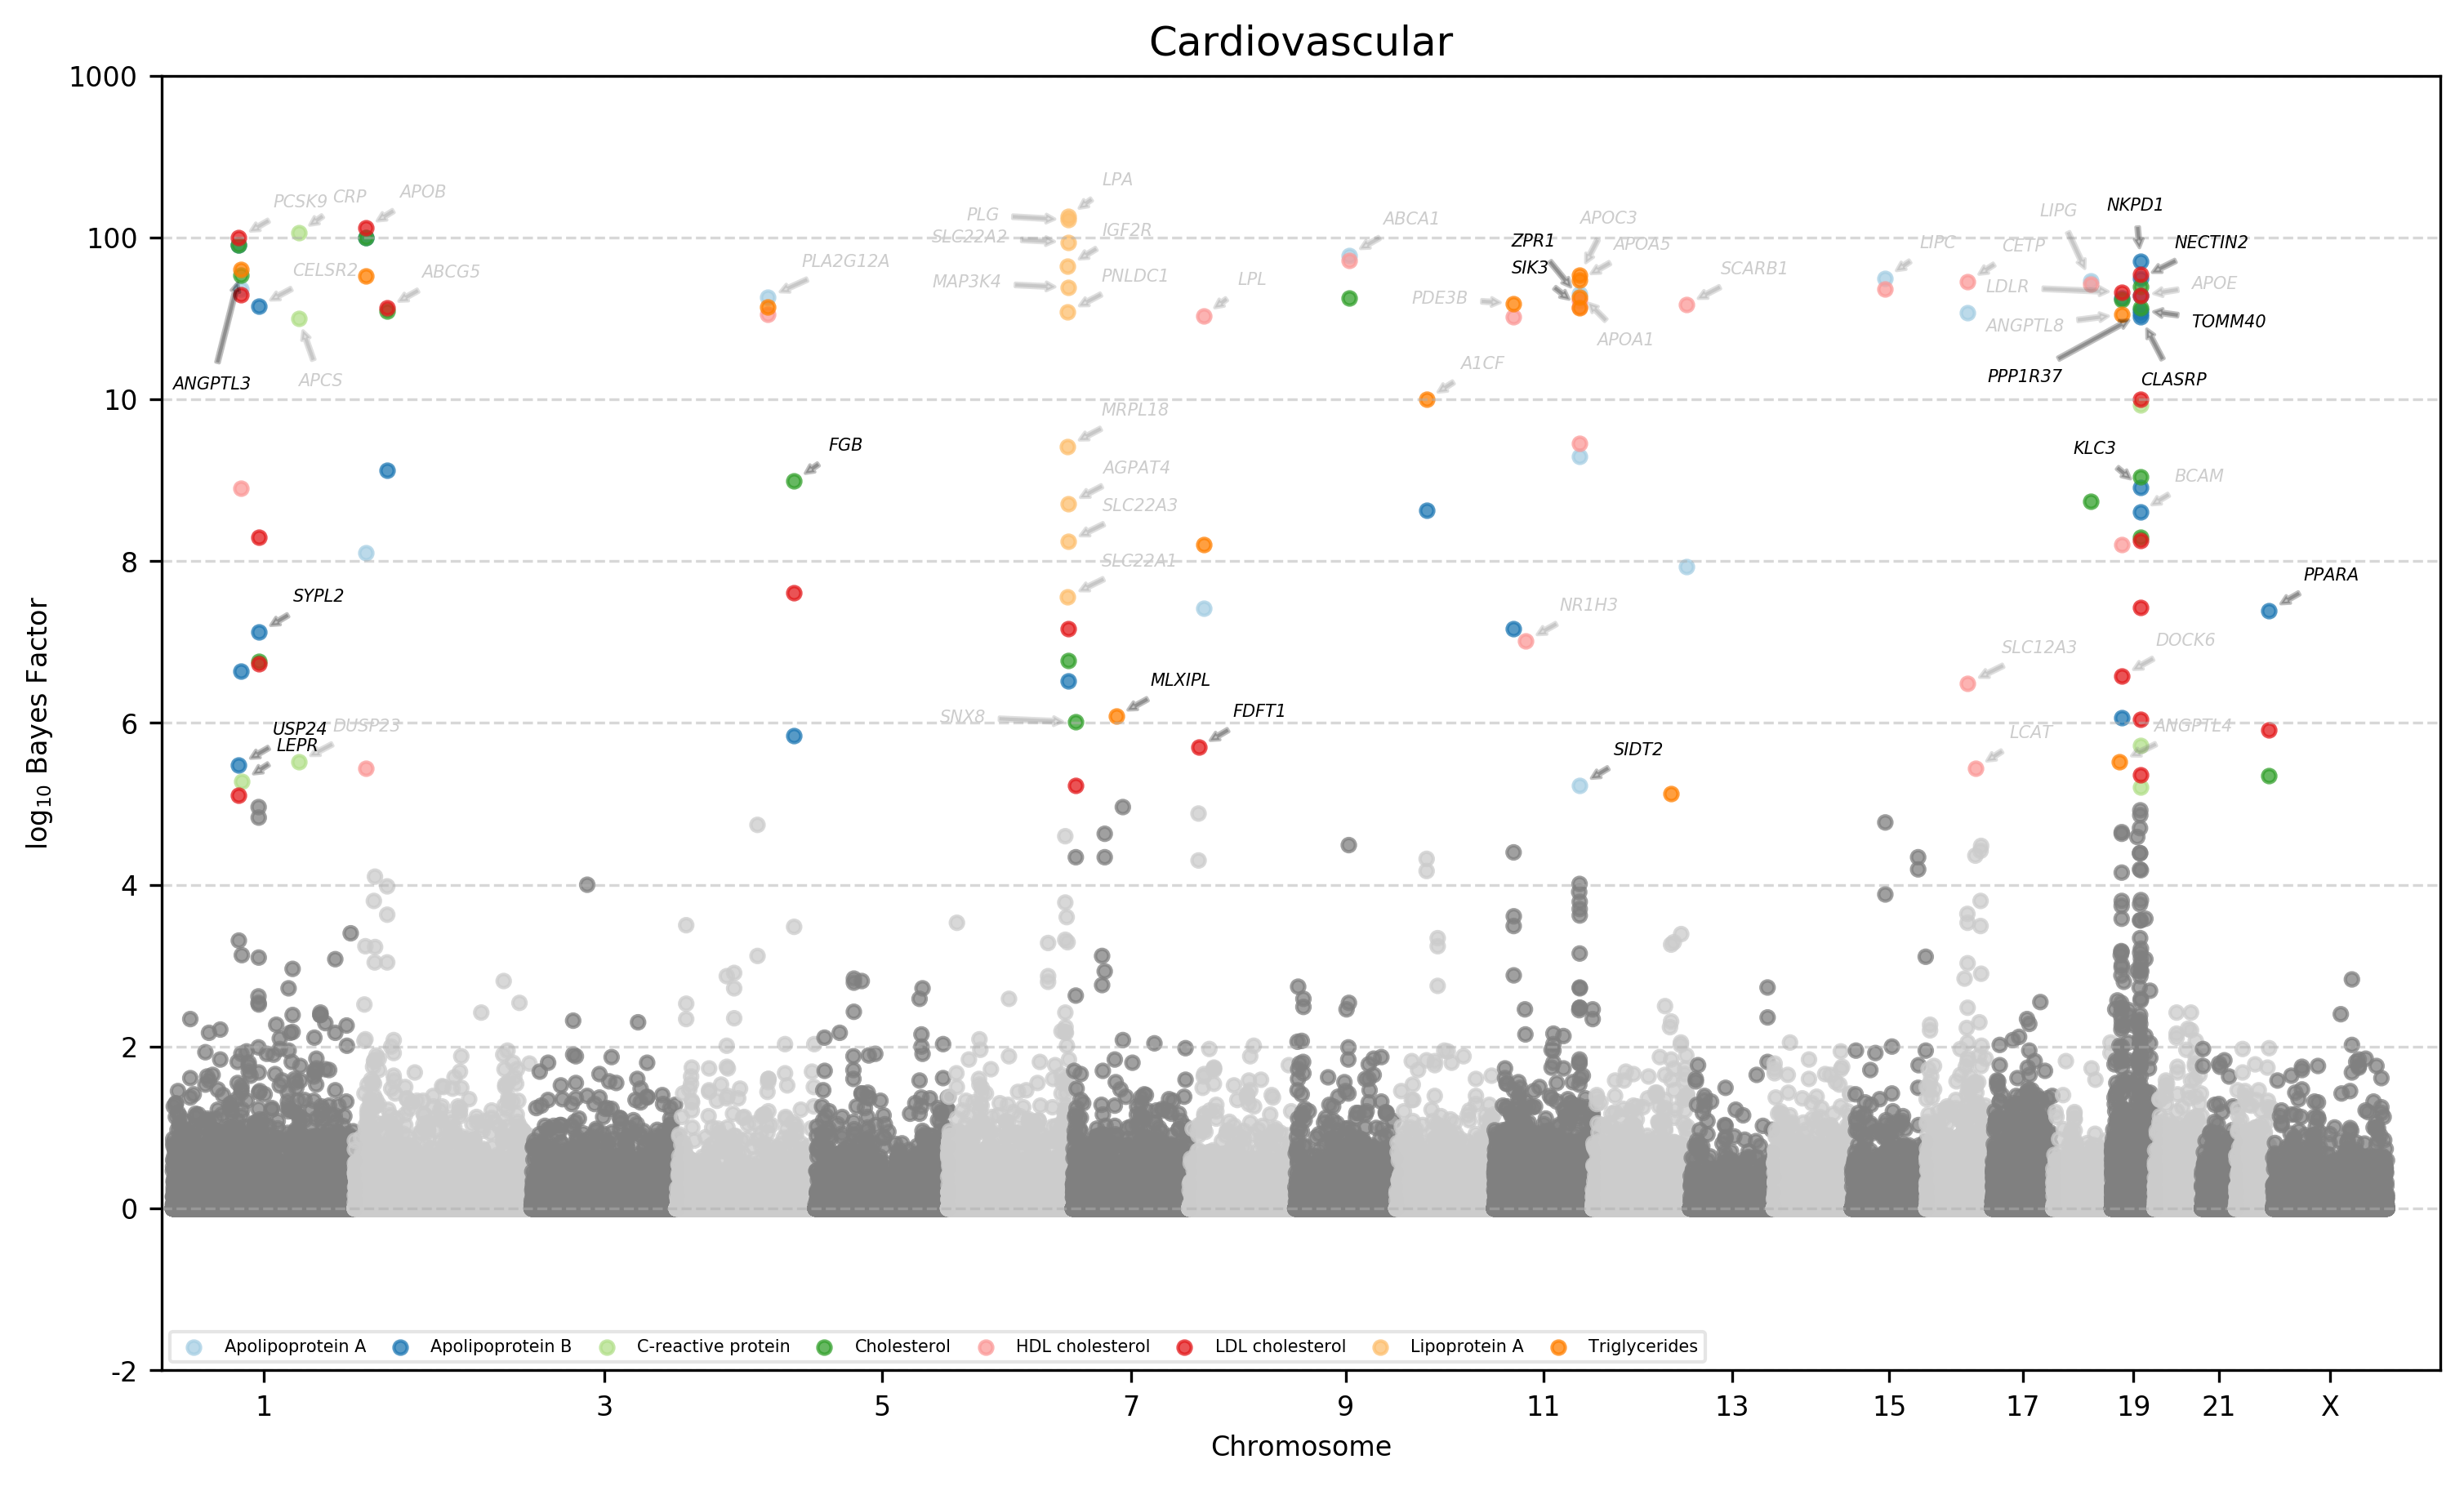

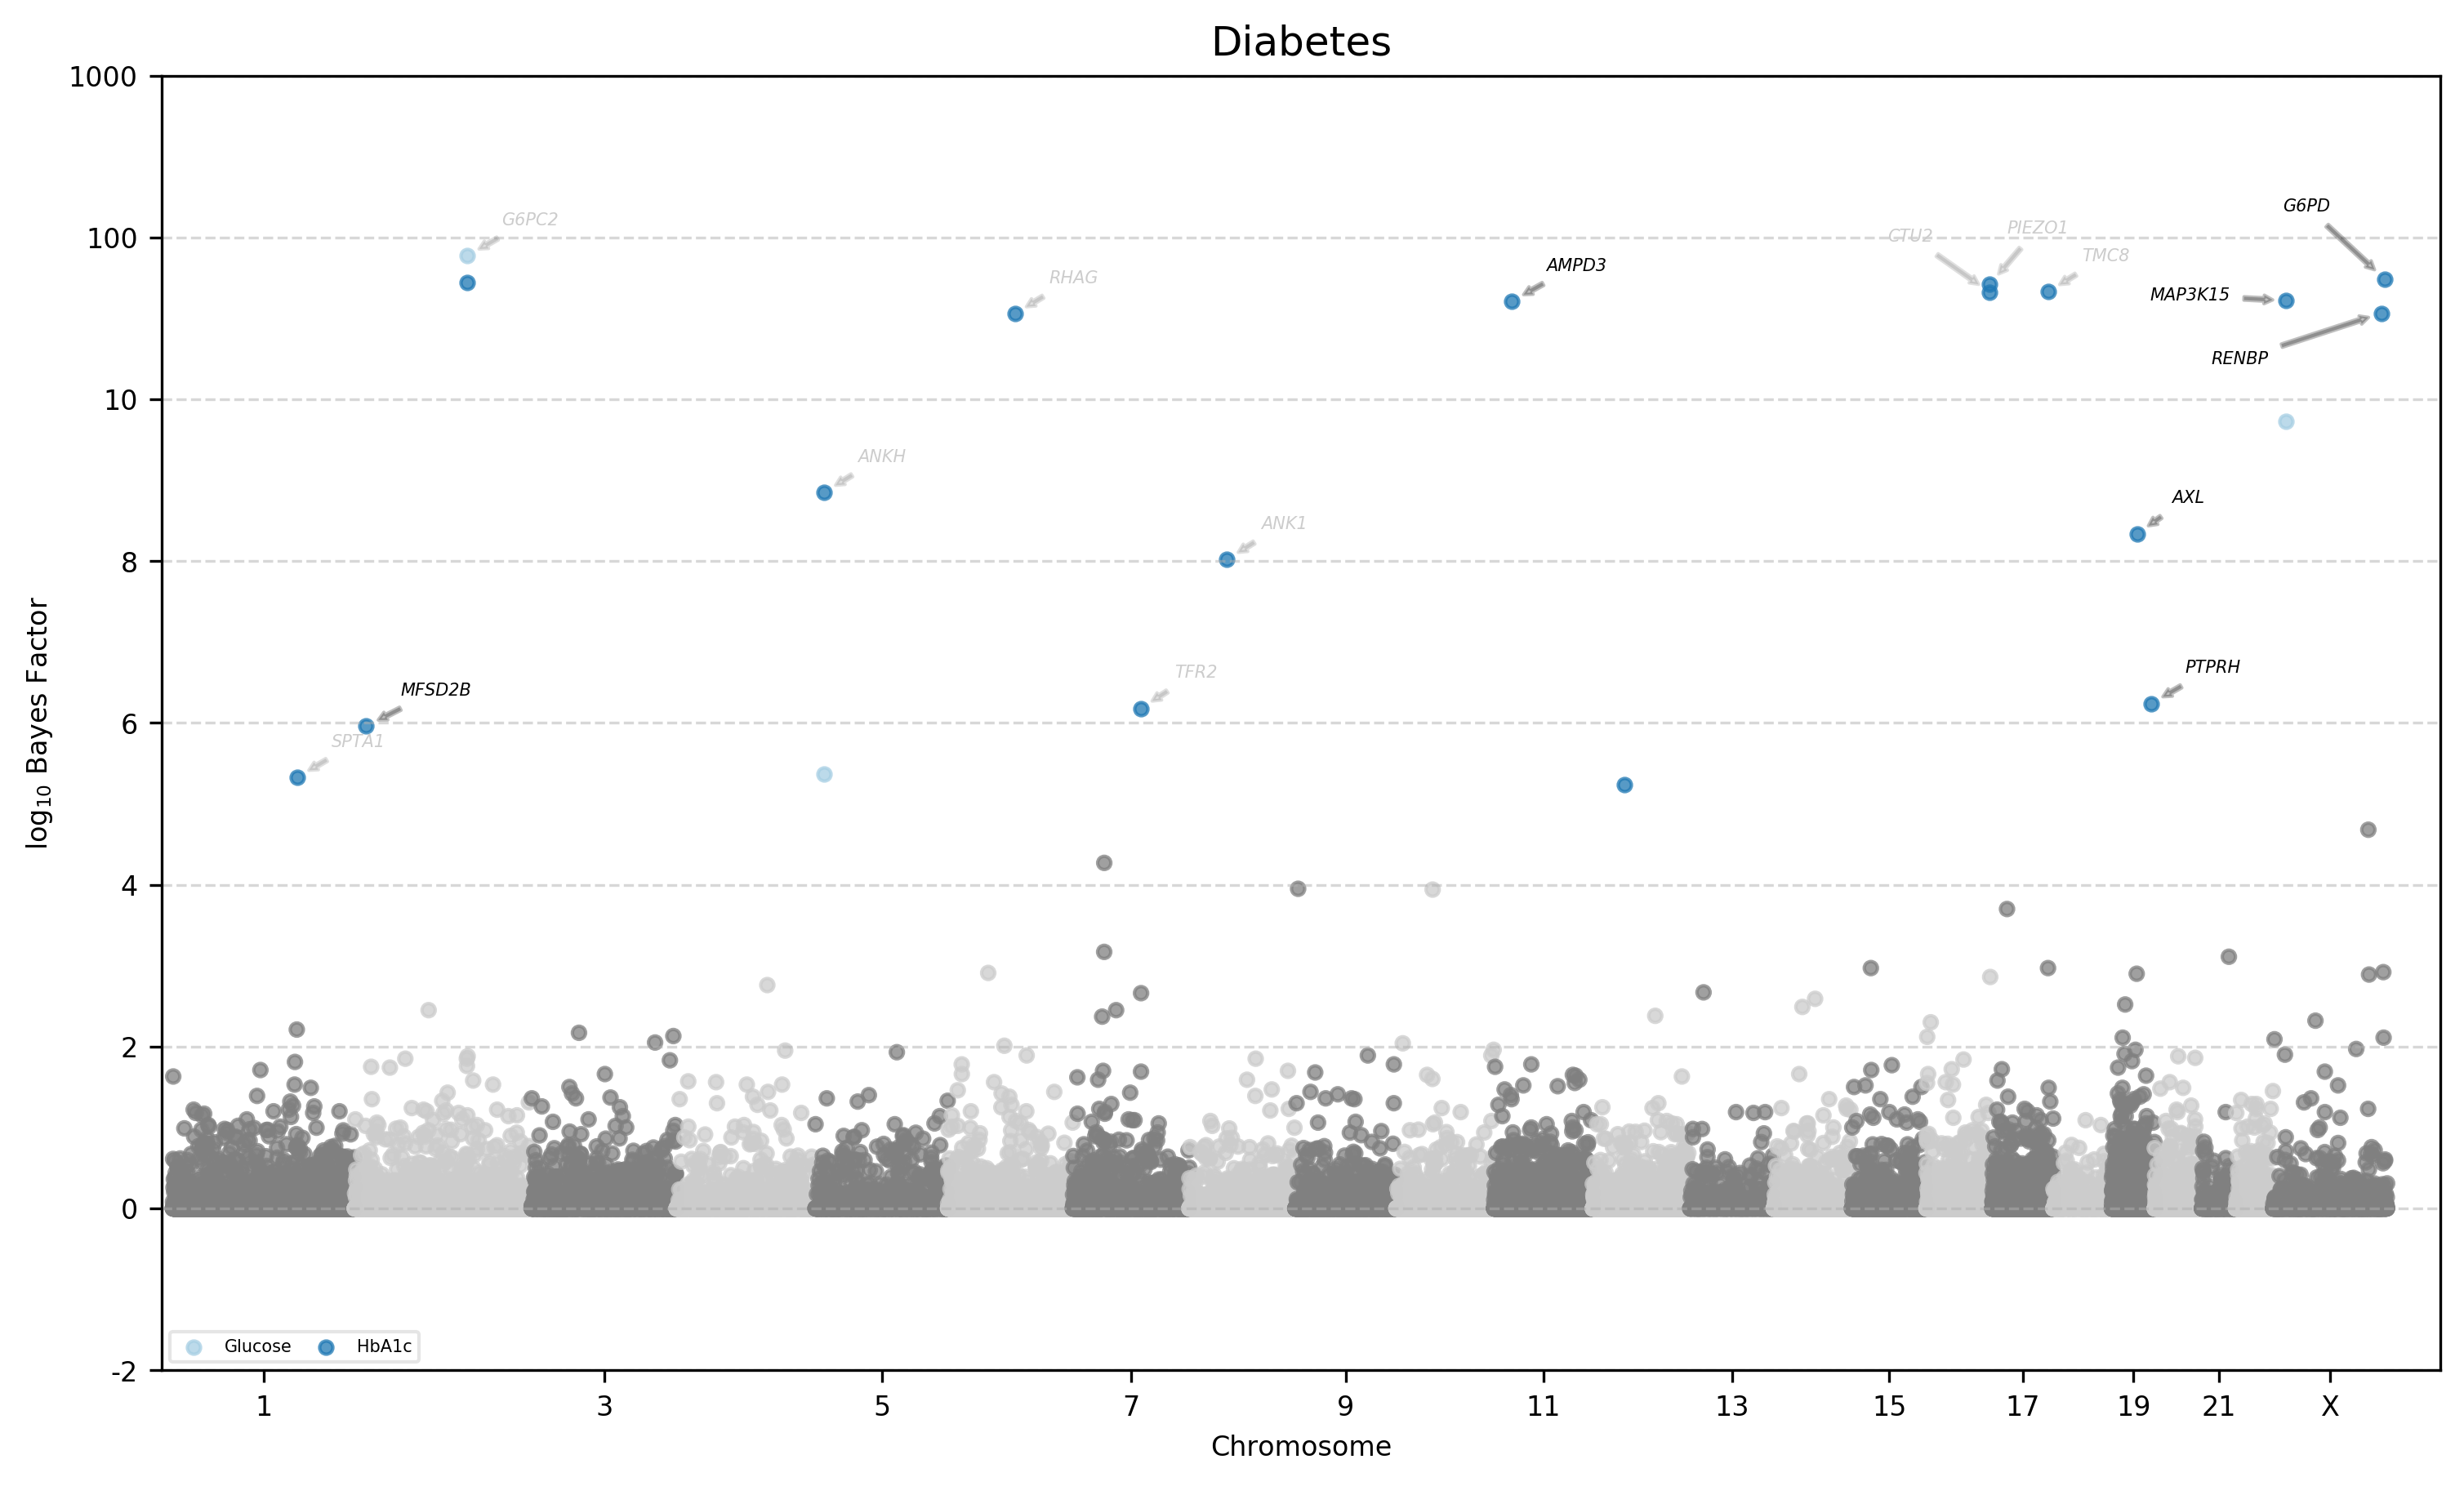

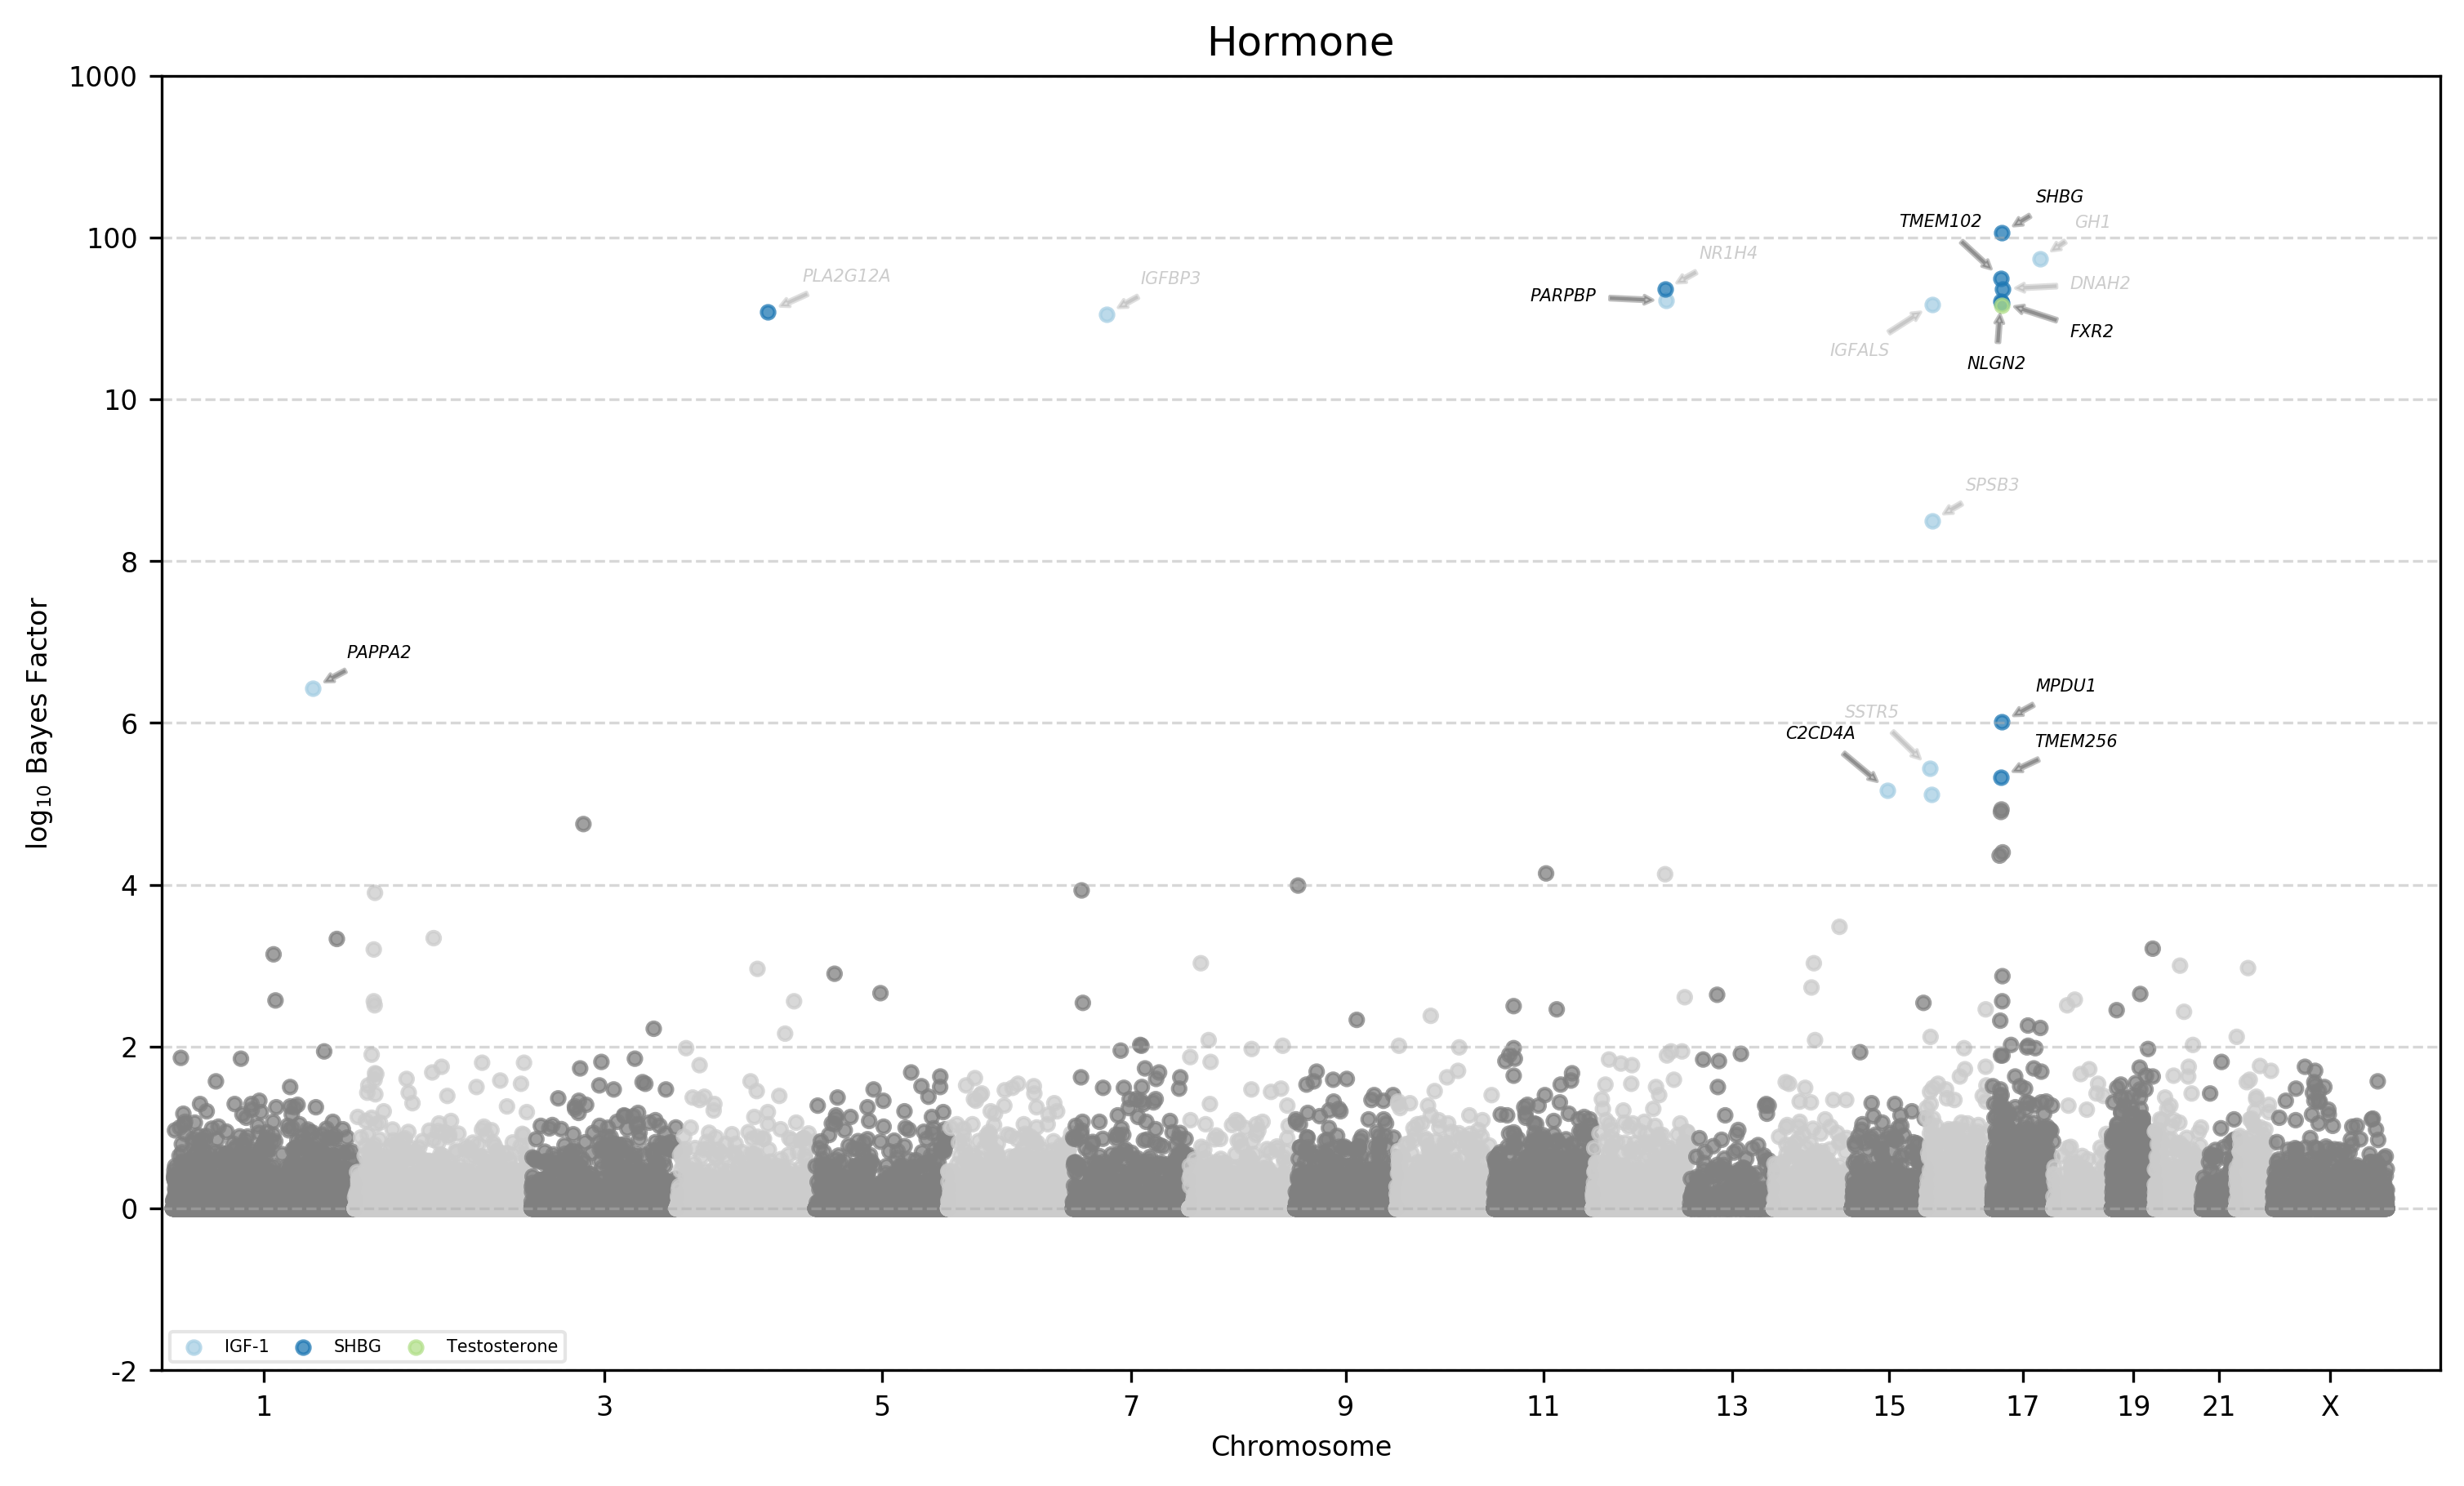

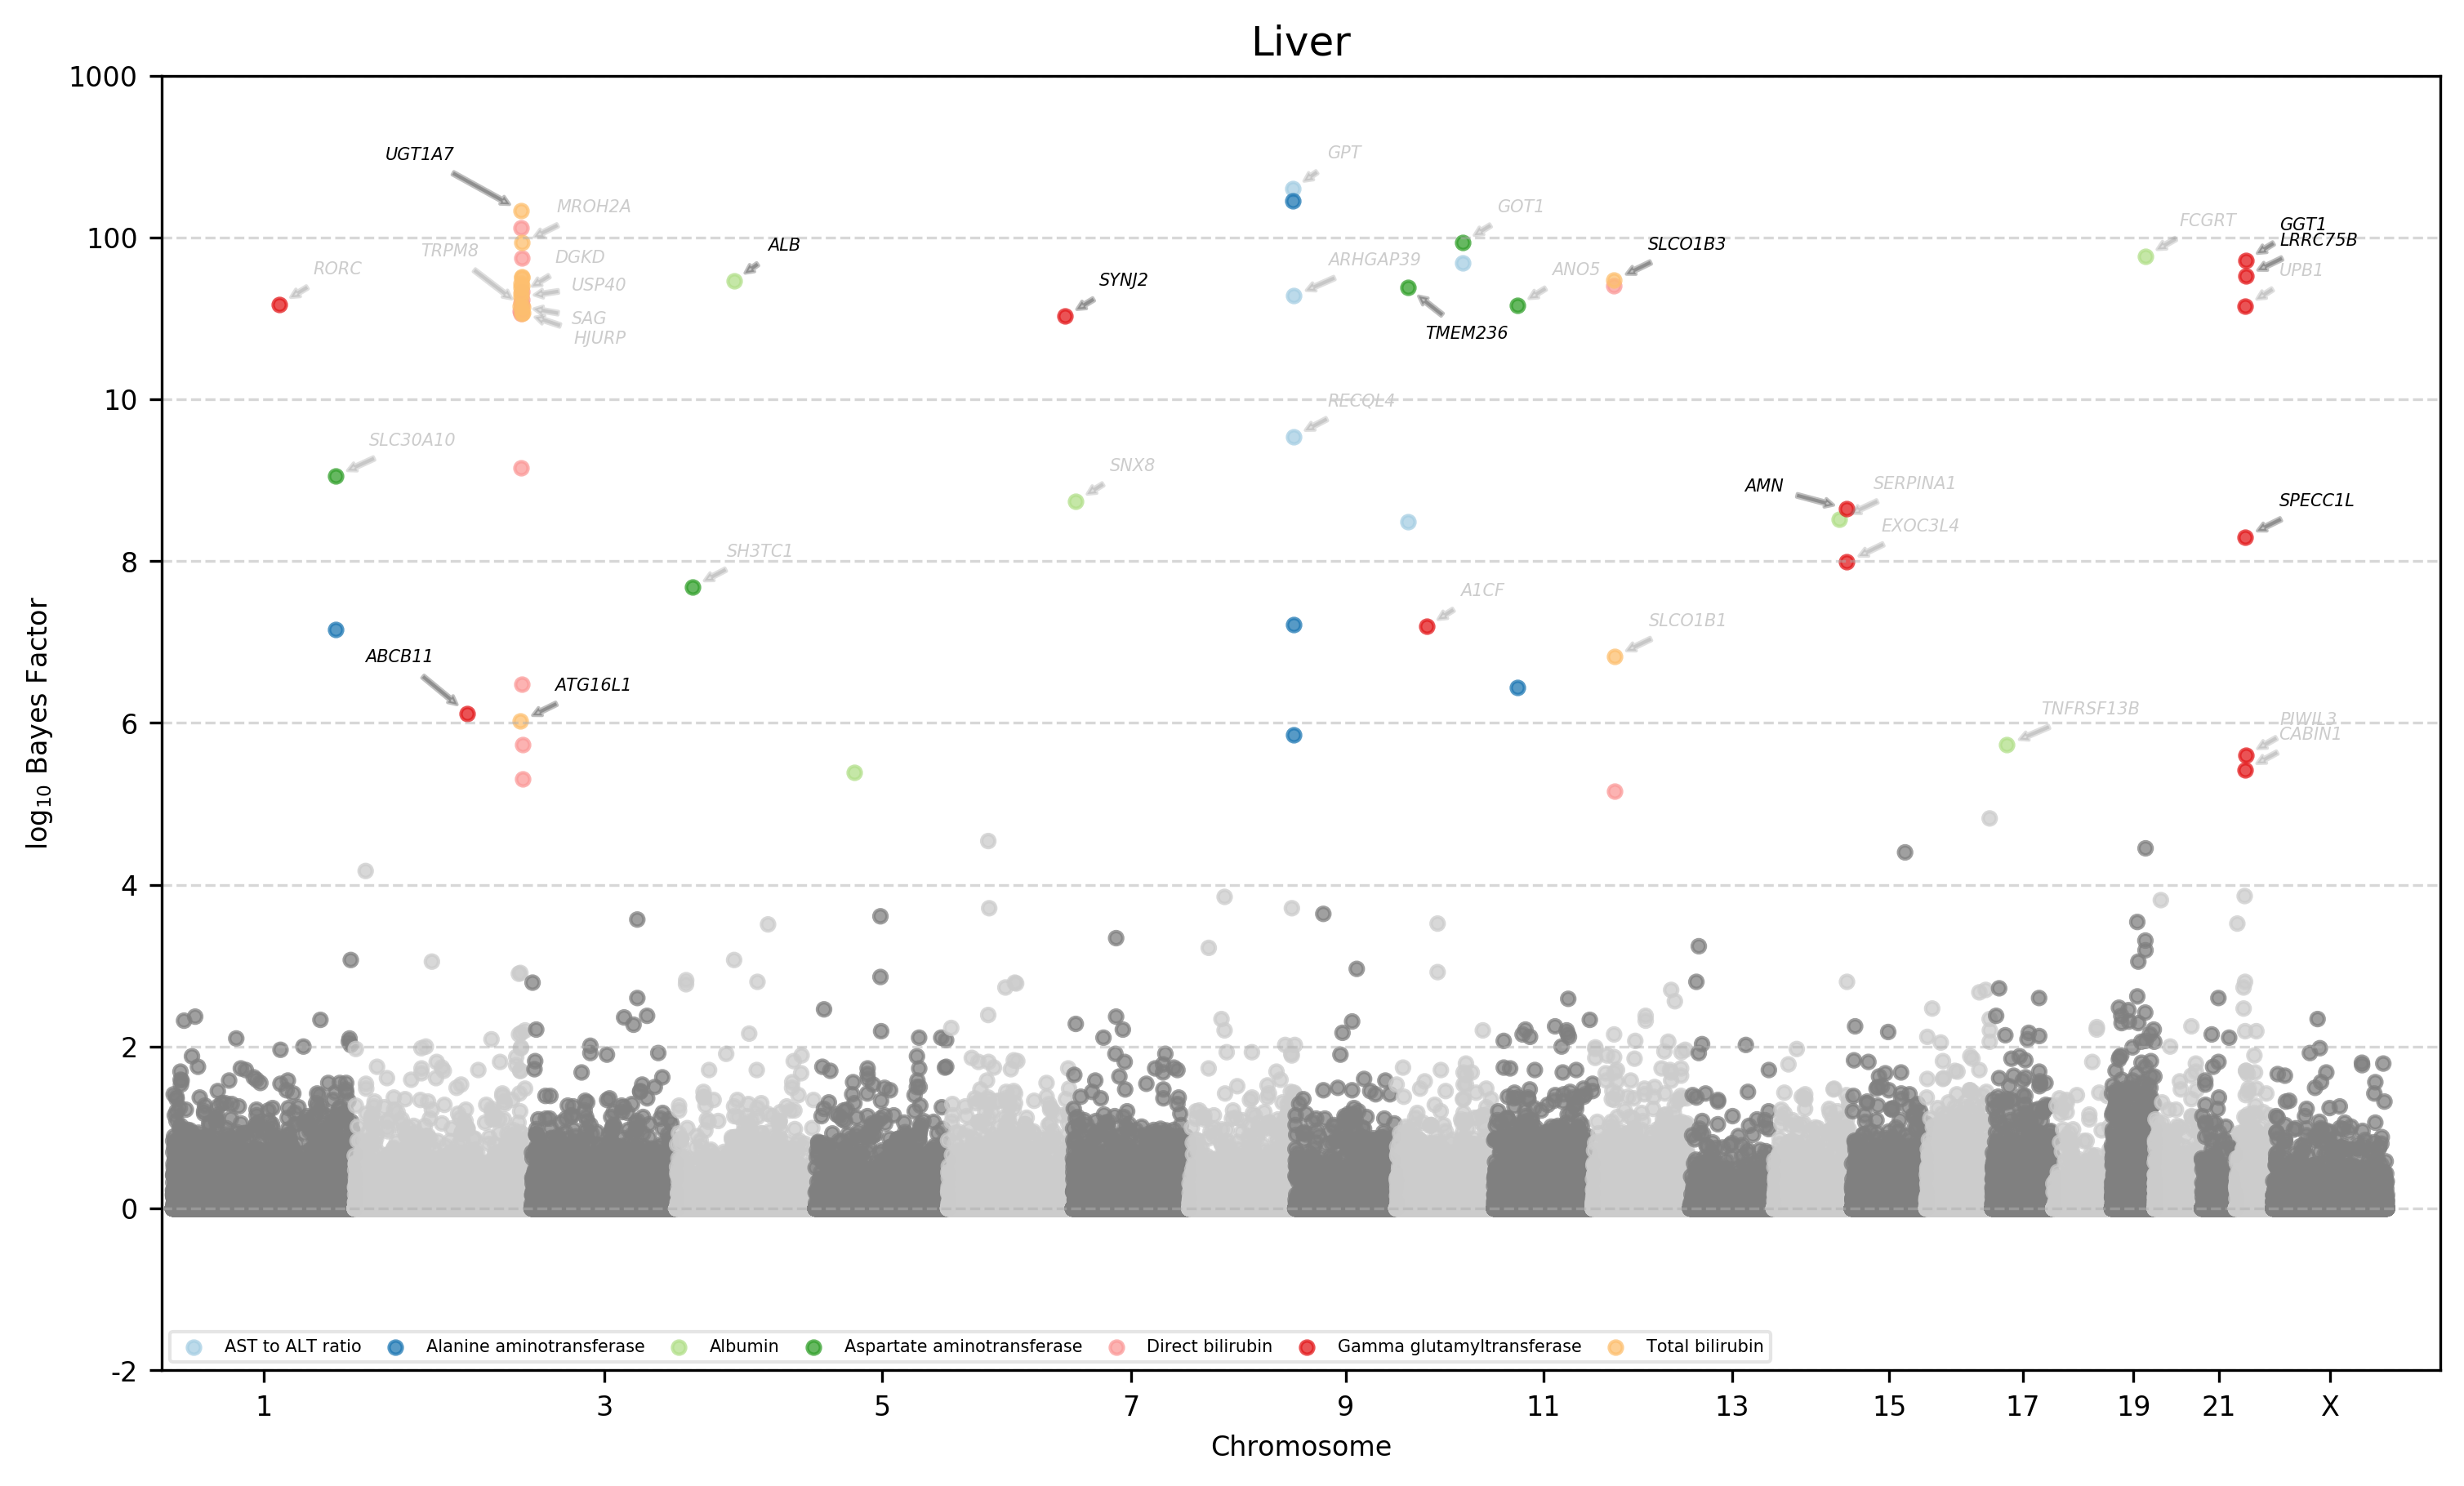

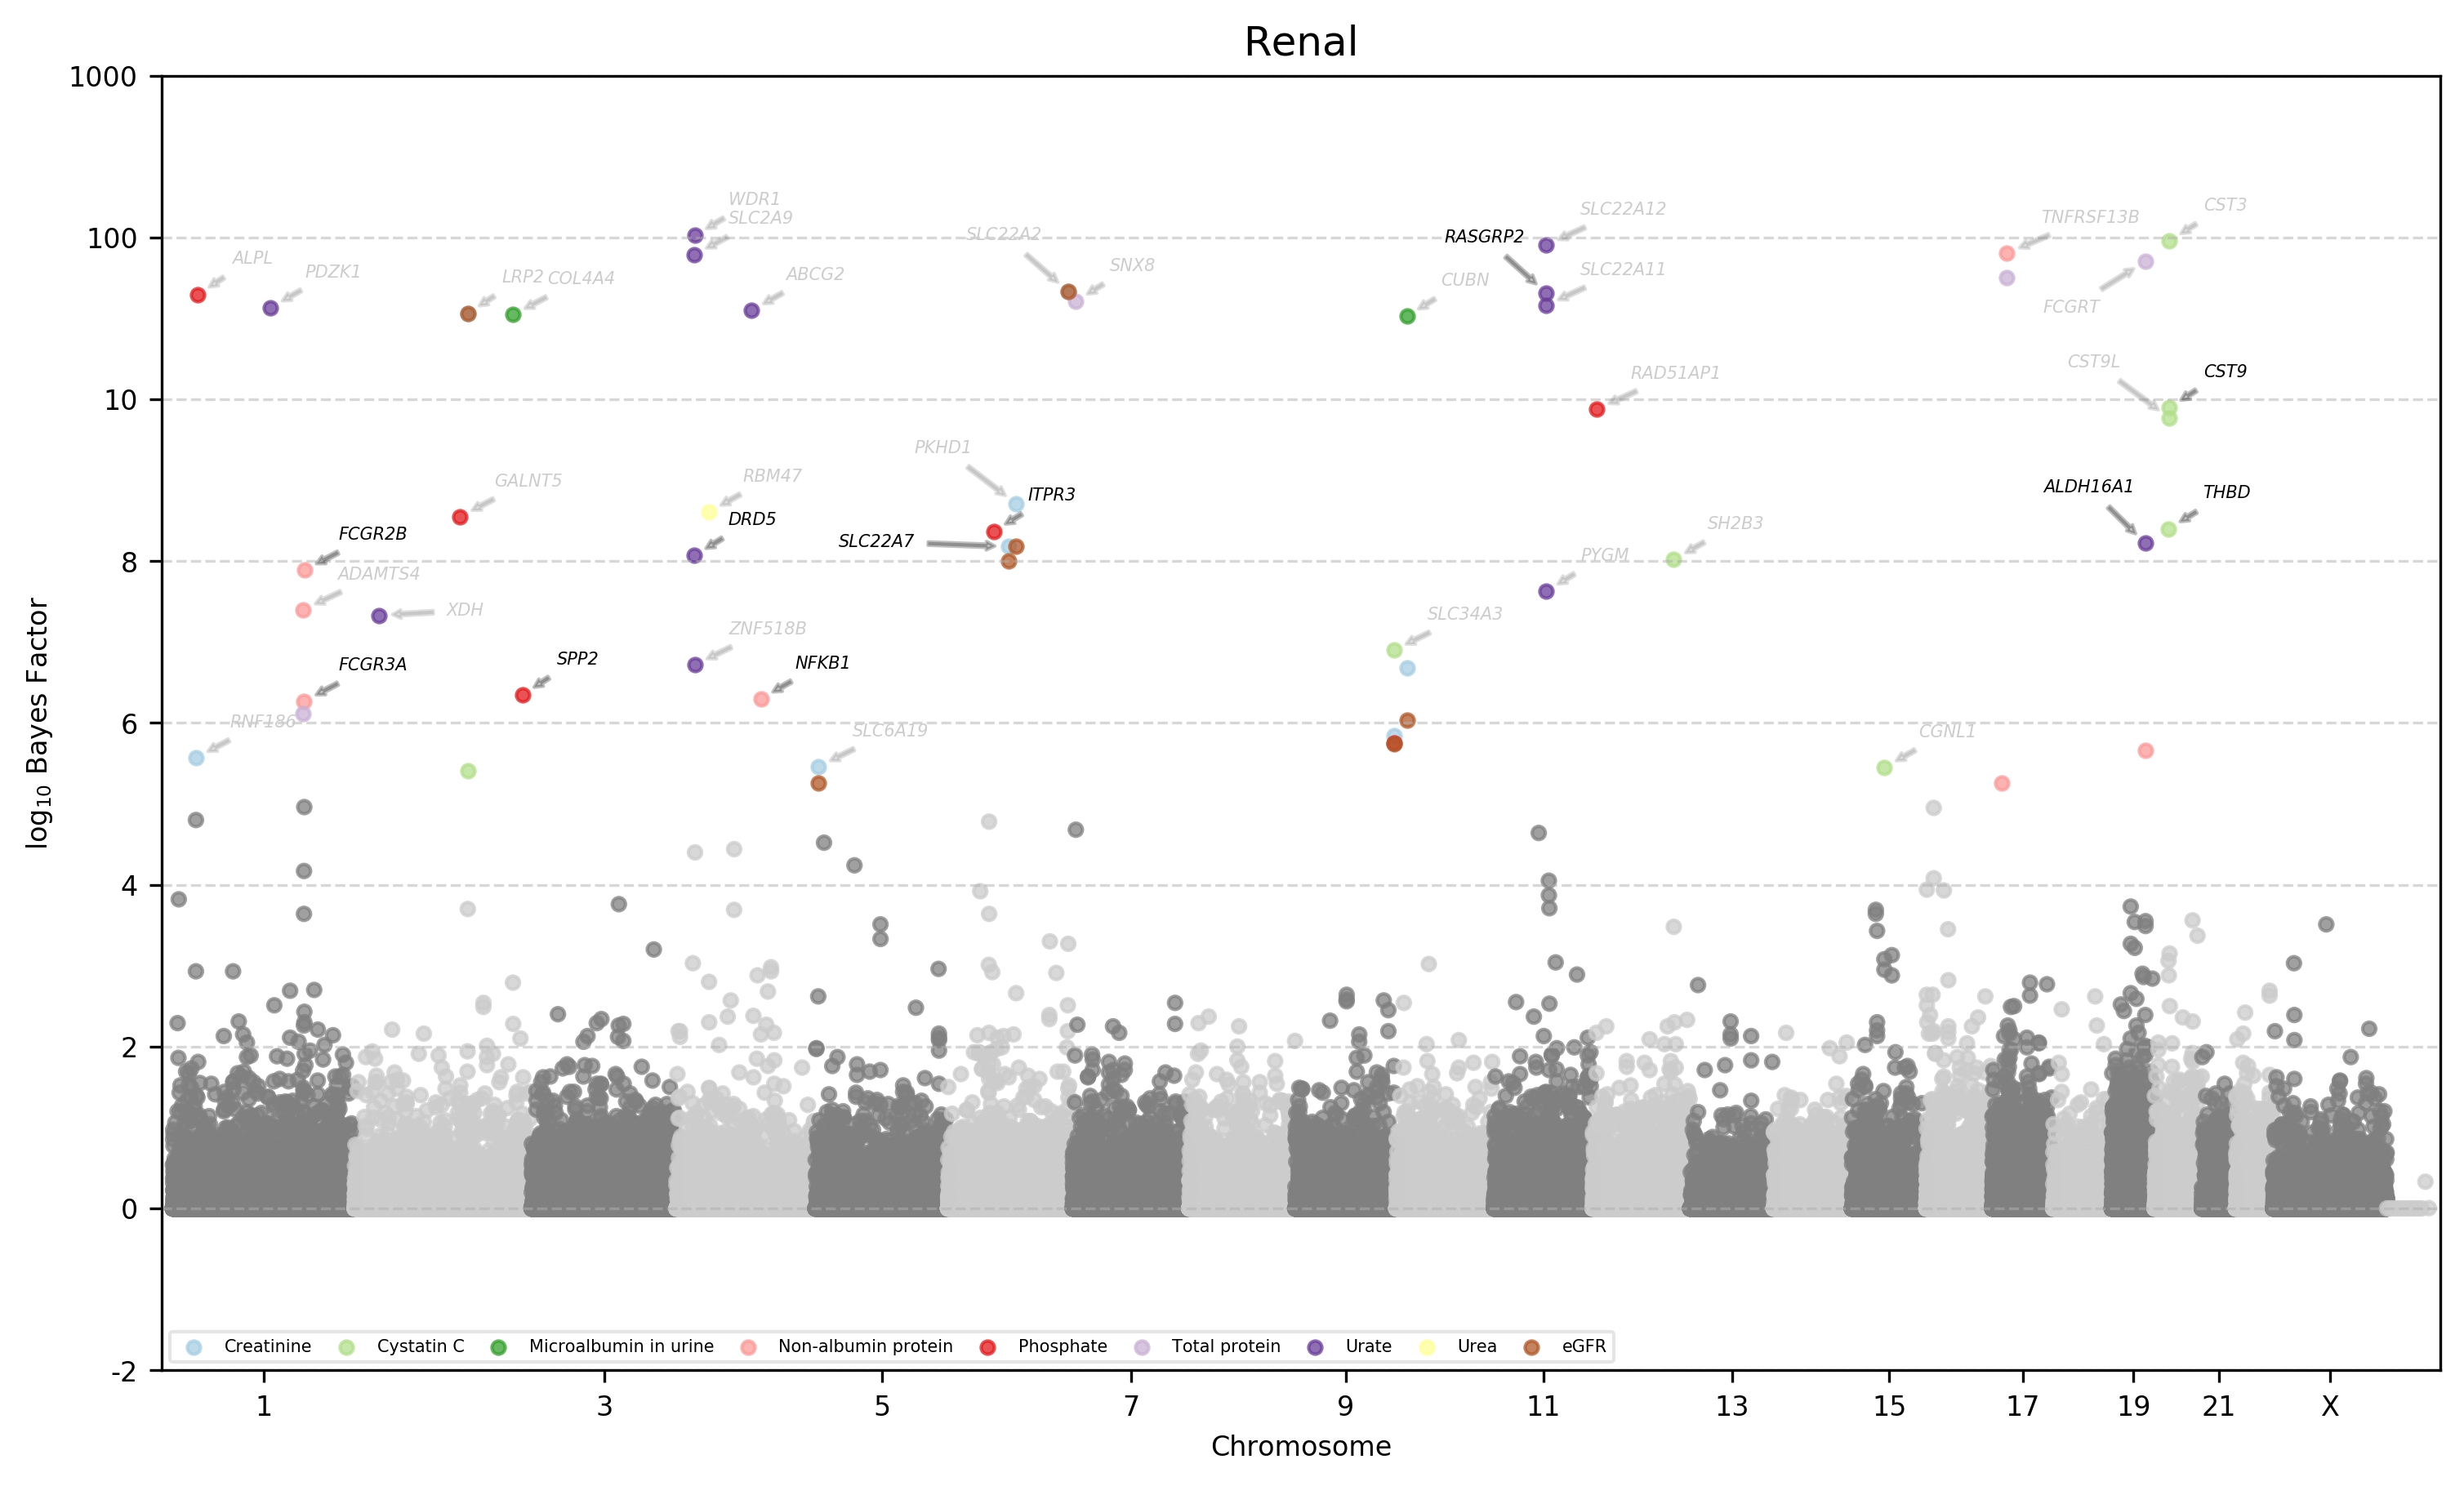

In [8]:
categories = ['Bone_and_Joint',
              'Cardiovascular',
              'Diabetes', 
              'Hormone', 
              'Liver',
              'Renal']
offset_list = [{'Alkaline phosphatase: PKD1': (-10,20), 'Vitamin D: PDE3B': (-30,-10), 'Alkaline phosphatase: NBPF3': (0, -20)},
               {'Lipoprotein A: SLC22A2': (-40, 0), 'Lipoprotein A: MAP3K4': (-40, 0), 'LDL cholesterol: LDLR': (-40, 0), 'Triglycerides: APOC3': (0, 15), 'Apolipoprotein A: APOA1': (5, -15), 'Apolipoprotein B: APOE': (15,2), 'Triglycerides: ANGPTL8': (-40, -5),'Apolipoprotein A: LIPG': (-15, 19), 'Triglycerides: PDE3B': (-30, 0), 'Apolipoprotein B: CLASRP': (0,-20), 'C-reactive protein: APCS': (0, -20), 'Triglycerides: ANGPTL3': (-20, -35), 'Lipoprotein A: PLG': (-30, 0), 'Cholesterol: SNX8': (-40, 0), 'Apolipoprotein B: TOMM40': (15,-5), 'Triglycerides: ZPR1': (-20,15), 'Triglycerides: SIK3': (-20,10), 'Apolipoprotein B: KLC3': (-20,10), 'Apolipoprotein B: NKPD1': (-10,15), 'Apolipoprotein B: PPP1R37': (-45,-20)},
               {'HbA1c: PIEZO1': (5, 15), 'HbA1c: CTU2': (-30, 15), 'HbA1c: RENBP': (-50,-15), 'HbA1c: G6PD': (-30,20), 'HbA1c: MAP3K15': (-40, 0)},
               {'IGF-1: IGFALS': (-30, -15), 'SHBG: TMEM102': (-30, 15), 'SHBG: DNAH2': (20, 0), 'SHBG: FXR2': (20, -10), 'IGF-1: PARPBP': (-40, 0), 'IGF-1: SSTR5': (-25, 15), 'IGF-1: C2CD4A': (-30,15), 'SHBG: NLGN2': (-10, -20)},
               {'Total bilirubin: SAG': (15,-5), 'Total bilirubin: USP40': (15,2), 'Total bilirubin: TRPM8': (-30,15), 'Total bilirubin: HJURP': (15,-9), 'Aspartate aminotransferase: TMEM236': (5,-15), 'Total bilirubin: UGT1A7': (-40,15), 'Gamma glutamyltransferase: AMN': (-30,5), 'Gamma glutamyltransferase: ABCB11': (-30,15)},
               {'Urate: XDH': (20, 0), 'Creatinine: PKHD1': (-30, 15), 'eGFR: SLC22A2': (-30, 15), 'Urate: RASGRP2': (-30, 15), 'Total protein: FCGRT': (-30, -15), 'Cystatin C: CST9L': (-30, 15), 'Urate: ALDH16A1': (-30, 15), 'Urate: ALDH16A1': (-30, 15), 'Creatinine: SLC22A7': (-50,0)}]
threshes = [5, 5, 5, 5, 5, 5]
for category, offset, thresh in zip(categories, offset_list, threshes):
    print(category)
    subset_bio = bio[bio['CATEGORY'] == category]
    subset_df = df[df['#GBE_ID'].isin(list(subset_bio['GBE_ID']))]
#     if category == 'Cardiovascular':
#         subset_df = subset_df[~(subset_df['GBE_short_name'] == 'Cholesterol') & ~(subset_df['GBE_short_name'] == 'Apolipoprotein A')& ~(subset_df['GBE_short_name'] == 'Apolipoprotein B')]
    showplot(subset_df.sort_values(['chrom', 'pos']), category.replace('_', ' '), offset, thresh)